(1280, 720)


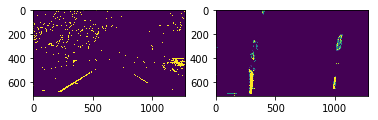

In [294]:
import cv2
import pickle
import matplotlib.pyplot as plt

M = pickle.load(open('topdown_transform.p', 'rb'))['M']
img_thresholded = cv2.imread('thresholded_images/result_5.png', 0) # What is the CV constant name?
img_size = img_thresholded.shape[::-1]
img_topdown = cv2.warpPerspective(img_thresholded, M, img_size, flags=cv2.INTER_LINEAR)
plt.subplot(1,2,1)
plt.imshow(img_thresholded)
plt.subplot(1,2,2)
plt.imshow(img_topdown)
print(img_size)

Lanes:
293 992


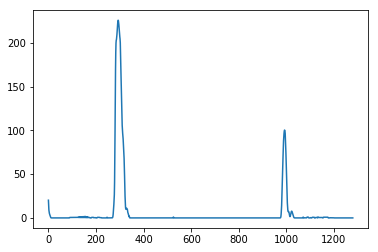

In [295]:
# Take bottom half of image, histogram it
import numpy as np

bottom = img_topdown[img_size[1]//2:, :] / 255
hist = np.sum(bottom, axis=0)
n_cols = len(hist)
plt.plot(hist)
left_lane = np.argmax(hist[:n_cols//2])
right_lane = np.argmax(hist[n_cols//2:]) + n_cols//2
print('Lanes:')
print(left_lane, right_lane)

20


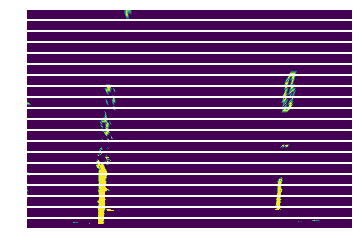

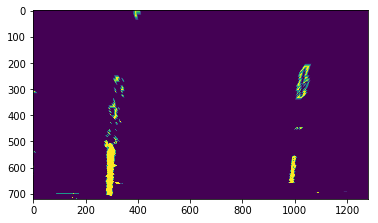

In [296]:
n_windows = 20
img_rowed = np.vsplit(img_topdown, n_windows)
n=len(img_rowed)
print(n)
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.imshow(img_rowed[i])
    plt.axis('off')
plt.figure()
plt.imshow(img_topdown)

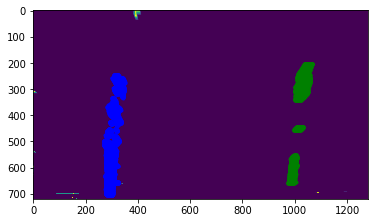

In [297]:
h_window = 70
v_window = len(img_topdown) / 20
initial_left_lane = left_lane
initial_right_lane = right_lane

curr_left_lane = left_lane
curr_right_lane = right_lane

left_lane_r = list()
right_lane_r = list()
left_lane_c = list()
right_lane_c = list()

for i in range(len(img_rowed)-1, -1, -1):
    rel_r_coords, c_coords = np.where(img_rowed[i])
    left_indices = np.where(np.abs(c_coords - curr_left_lane) < h_window / 2)
    right_indices = np.where(np.abs(c_coords - curr_right_lane) < h_window / 2)
    left_lane_r.append(rel_r_coords[left_indices] + i*v_window)
    right_lane_r.append(rel_r_coords[right_indices] + i*v_window)
    left_lane_c.append(c_coords[left_indices])
    right_lane_c.append(c_coords[right_indices])
    
    if len(c_coords[left_indices]) > 0:
        curr_left_lane = np.mean(c_coords[left_indices])
    if len(c_coords[right_indices]) > 0:
        curr_right_lane = np.mean(c_coords[right_indices])


left_lane_r = np.concatenate(left_lane_r)
right_lane_r = np.concatenate(right_lane_r)
left_lane_c = np.concatenate(left_lane_c)
right_lane_c = np.concatenate(right_lane_c)



## Display =========================

plt.imshow(img_topdown)
plt.plot(left_lane_c, left_lane_r, 'b.')
plt.plot(right_lane_c, right_lane_r, 'g.')

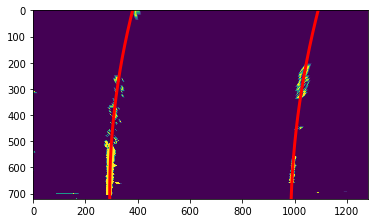

In [300]:
# Fit a second order polynomial to pixel positions in each fake lane line


ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
ploty = ploty[::-1]

left_fit = np.polyfit(left_lane_r, left_lane_c, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(right_lane_r, right_lane_c, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.imshow(img_topdown)

# plt.plot(left_lane_c, left_lane_r, 'o', color='red', markersize=mark_size)
# plt.plot(right_lane_c, right_lane_r, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='red', linewidth=3)
plt.plot(right_fitx, ploty, color='red', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.savefig('polyfit/color_lane_lines.png')

In [281]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

2325.9645118111425 2643.0668239061547


In [282]:
# Define conversions in x and y from pixels space to meters
leftx = left_lane_c
lefty = left_lane_r
rightx = right_lane_c
righty = right_lane_r

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

763.1414664928517 m 867.6189649657548 m


In [283]:

# ym_per_pix : meters per pixel in y dimension (see previous sections)
# xm_per_pix : meters per pixel in x dimension (see previous sections)

base_row = img_size[1] - 1
left_base = left_fit[0]*base_row**2 + left_fit[1]*base_row + left_fit[2]
right_base = right_fit[0]*base_row**2 + right_fit[1]*base_row + right_fit[2]

vehicle_center = img_size[0] / 2 # About 600
lane_center = (left_base + right_base) / 2
offset_pix = vehicle_center - lane_center
print(offset_pix) # Negative means to the left, positive to the right
print(offset_pix * xm_per_pix, ' m') # Offset in meters

-10.351090335857407
-0.05471290606096058  m


In [284]:
import pickle

parameters = dict()
parameters['left_fitx'] = left_fitx
parameters['right_fitx'] = right_fitx
parameters['ploty'] = ploty
pickle.dump(parameters, open('poly-fit.p', 'wb'))